<a href="https://colab.research.google.com/github/G0nkly/Ready-Set-Prophecy/blob/main/Optimization_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install mip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.1/484.1 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 29.3 MB/s eta 0:00:00
  Created wheel for cffi: filename=cffi-1.15.0-cp312-cp312-linux_x86_64.whl size=400940 sha256=3c31b093319811605ae35d5875ed9dee87839c601c6876871ab7653a568eb2a4
  Stored in directory: /root/.cache/pip/wheels/b9/d6/15/0950847bf7d74ea5f0380b8b23a1d81b45bdf48488b4b8237a
Successfully built cffi
  Attempting uninstall: cffi
    Found existing installation: cffi 2.0.0
    Uninstalling cffi-2.0.0:
      Successfully uninstalled cffi-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rpy2 3.5.17 requires cffi>=1.15.1, but you have cffi 1.15.0 which is incompatible.
pygit2 1.19.1 requires cffi>=2.0, but you have cffi 1.15.0 which is incompatible.


# **Approach**

#### **Starting point**


*   What can I *decide* => **Variables**
*   What *must not happen* => **Constraints**
*   What to *optimize* => ***Goal***




### **Example I - simple Dispatch**
Scenario: 3 Powerplants, 4 hours, demnad must be met, minimal costs

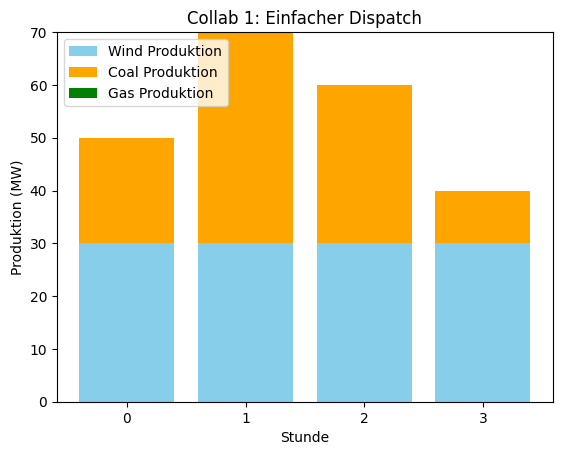

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

hours = 4
plants = ["Wind", "Coal", "Gas"]
capacity = np.array([30, 50, 40])
cost = np.array([10, 20, 30])
demand = np.array([50, 70, 60, 40])

# Kostenvektor & Bounds
n_vars = hours * len(plants)
cost_vector = np.tile(cost, hours)
bounds = [(0, c) for _ in range(hours) for c in capacity]

# Nachfrage constraints
A_eq = np.zeros((hours, n_vars))
for t in range(hours):
    for p in range(len(plants)):
        A_eq[t, t*len(plants)+p] = 1
b_eq = demand

# Optimierung
res = linprog(cost_vector, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
collab1 = res.x.reshape(hours, len(plants))

# Plot-Funktion
def plot_collab1(data):
    bottom = np.zeros(hours)
    colors = ["skyblue", "orange", "green"]
    for p in range(len(plants)):
        plt.bar(range(hours), data[:,p], bottom=bottom, color=colors[p], label=f"{plants[p]} Produktion")
        bottom += data[:,p]
    plt.xlabel("Stunde")
    plt.ylabel("Produktion (MW)")
    plt.title("Collab 1: Einfacher Dispatch")
    plt.xticks(range(hours))
    plt.legend()
    plt.show()

plot_collab1(collab1)

### **Example II - Dispatch + Ramp up / down**
Scenario: Scenario: 3 Powerplants, 4 hours, demnad must be met, minimal costs, power plants have ramp up/down limits

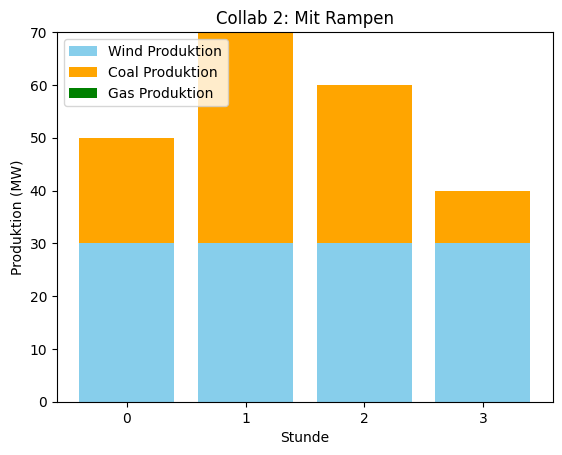

In [28]:
# Rampen Limits
ramp_up = np.array([10, 20, 15])
ramp_down = np.array([10, 20, 15])

# Ungleichungen vorbereiten
A_ub, b_ub = [], []
for t in range(1, hours):
    for p in range(len(plants)):
        row_up = np.zeros(n_vars); row_up[t*len(plants)+p] = 1; row_up[(t-1)*len(plants)+p] = -1
        row_down = np.zeros(n_vars); row_down[t*len(plants)+p] = -1; row_down[(t-1)*len(plants)+p] = 1
        A_ub.append(row_up); b_ub.append(ramp_up[p])
        A_ub.append(row_down); b_ub.append(ramp_down[p])
A_ub = np.array(A_ub); b_ub = np.array(b_ub)

# Optimierung
res = linprog(cost_vector, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')
collab2 = res.x.reshape(hours, len(plants))

# Plot-Funktion
def plot_collab2(data):
    bottom = np.zeros(hours)
    colors = ["skyblue", "orange", "green"]
    for p in range(len(plants)):
        plt.bar(range(hours), data[:,p], bottom=bottom, color=colors[p], label=f"{plants[p]} Produktion")
        bottom += data[:,p]
    plt.xlabel("Stunde")
    plt.ylabel("Produktion (MW)")
    plt.title("Collab 2: Mit Rampen")
    plt.xticks(range(hours))
    plt.legend()
    plt.show()

plot_collab2(collab2)

### **Example III - Dispatch + Ramp up/down + Maintenance phases**
Scenario: Scenario: 3 Powerplants, 4 hours, demnad must be met, minimal costs, power plants have ramp up/down limits, power plants are shut down for maintenance

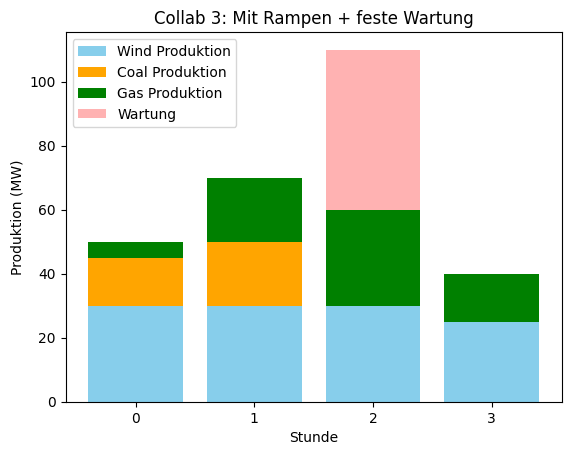

In [29]:
# Feste Wartung: Coal Stunde 2
bounds_wm = bounds.copy()
bounds_wm[2*len(plants)+1] = (0,0)  # Coal Stunde 2

res = linprog(cost_vector, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds_wm, method='highs')
collab3 = res.x.reshape(hours, len(plants))

# Plot-Funktion
def plot_collab3(data):
    bottom = np.zeros(hours)
    colors = ["skyblue", "orange", "green"]
    for p in range(len(plants)):
        plt.bar(range(hours), data[:,p], bottom=bottom, color=colors[p], label=f"{plants[p]} Produktion")
        bottom += data[:,p]
    # Wartung markieren (Coal Stunde 2)
    plt.bar(2, capacity[1], bottom=bottom[2]-data[2,1], color='red', alpha=0.3, label="Wartung")
    plt.xlabel("Stunde")
    plt.ylabel("Produktion (MW)")
    plt.title("Collab 3: Mit Rampen + feste Wartung")
    plt.xticks(range(hours))
    plt.legend()
    plt.show()

plot_collab3(collab3)

### **Example IV - Dispatch + Ramp up/down + flexible maintenance**
Scenario: Scenario: 3 Powerplants, 4 hours, demnad must be met, minimal costs, power plants have ramp up/down limits, power plants have flexible maintenance phases



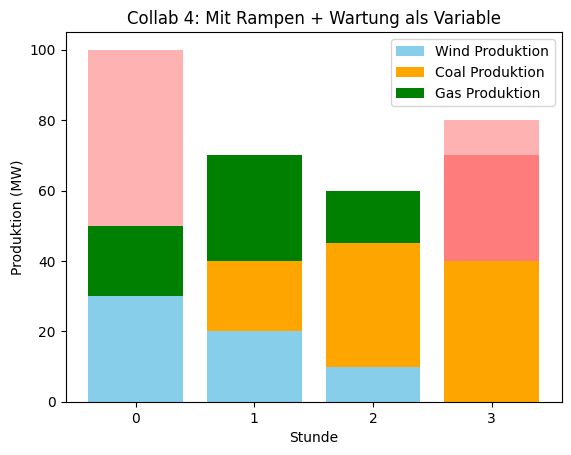

In [30]:
from mip import Model, xsum, BINARY, CONTINUOUS, MINIMIZE, OptimizationStatus

m = Model(sense=MINIMIZE)
x = [[m.add_var(var_type=CONTINUOUS, lb=0, ub=capacity[p]) for p in range(len(plants))] for t in range(hours)]
m_var = [[m.add_var(var_type=BINARY) for p in range(len(plants))] for t in range(hours)]

# Produktionslimit durch Wartung
for t in range(hours):
    for p in range(len(plants)):
        m += x[t][p] <= capacity[p]*m_var[t][p]

# Nachfrage
for t in range(hours):
    m += xsum(x[t][p] for p in range(len(plants))) == demand[t]

# Rampen
for t in range(1,hours):
    for p in range(len(plants)):
        m += x[t][p] - x[t-1][p] <= ramp_up[p]
        m += x[t-1][p] - x[t][p] <= ramp_down[p]

# Mindest-Wartung
for p in range(len(plants)):
    m += xsum(1 - m_var[t][p] for t in range(hours)) >= 1

# Kosten
m.objective = xsum(cost[p]*x[t][p] for t in range(hours) for p in range(len(plants)))

status = m.optimize()

collab4 = np.zeros((hours,len(plants)))
collab4_running = np.zeros((hours,len(plants)))
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    for t in range(hours):
        for p in range(len(plants)):
            collab4[t,p] = x[t][p].x
            collab4_running[t,p] = m_var[t][p].x

# Plot-Funktion
def plot_collab4(data, running):
    bottom = np.zeros(hours)
    colors = ["skyblue", "orange", "green"]
    for p in range(len(plants)):
        plt.bar(range(hours), data[:,p], bottom=bottom, color=colors[p], label=f"{plants[p]} Produktion")
        bottom += data[:,p]
    # Wartung als halbtransparente Balken
    for t in range(hours):
        for p in range(len(plants)):
            if running[t,p]<0.5:
                plt.bar(t, capacity[p], bottom=bottom[t]-data[t,p], color='red', alpha=0.3)
    plt.xlabel("Stunde")
    plt.ylabel("Produktion (MW)")
    plt.title("Collab 4: Mit Rampen + Wartung als Variable")
    plt.xticks(range(hours))
    plt.legend()
    plt.show()

plot_collab4(collab4, collab4_running)

Mindestwartung (A_mw):
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]
b_mw: [3 3 3]

Max. 1 Kraftwerk gleichzeitig (A_max1):
[[-1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1.]]
b_max1: [2 2 2 2]


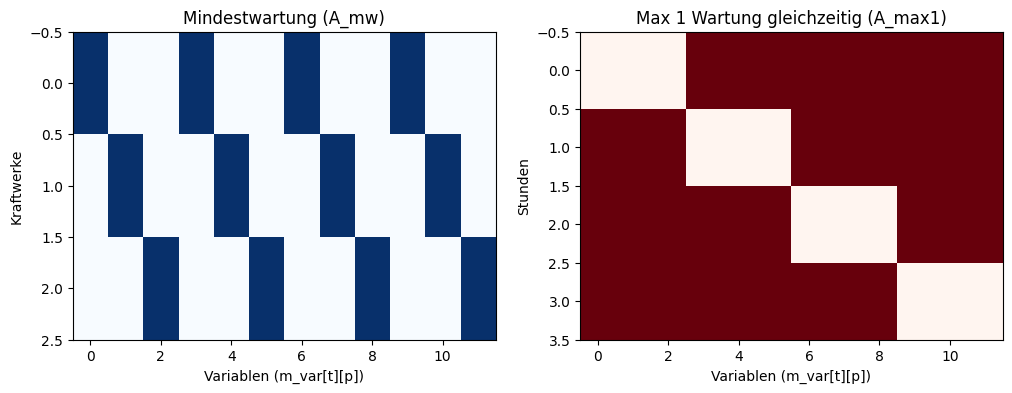

In [31]:
import numpy as np
import matplotlib.pyplot as plt

hours = 4
plants = ["Wind", "Coal", "Gas"]

# --- Mindestwartung (jede Anlage mindestens 1 Stunde) ---
# Zeilen = Kraftwerke, Spalten = Variablen m_var[t][p]
A_mw = np.zeros((len(plants), hours*len(plants)))

for p in range(len(plants)):
    for t in range(hours):
        A_mw[p, t*len(plants)+p] = 1  # m_var[t][p]

# Ungleichung: sum(1 - m_var) >= 1 --> sum(m_var) <= hours - 1
b_mw = np.array([hours - 1]*len(plants))

print("Mindestwartung (A_mw):")
print(A_mw)
print("b_mw:", b_mw)

# --- Maximal 1 Kraftwerk gleichzeitig in Wartung ---
A_max1 = np.zeros((hours, hours*len(plants)))

for t in range(hours):
    for p in range(len(plants)):
        A_max1[t, t*len(plants)+p] = -1  # -(m_var) -> sum(1 - m_var) <= 1 -> -sum(m_var) <= 1 - len(plants)
b_max1 = np.array([-(1 - len(plants))]*hours)  # -sum(m_var) <= 1 - len(plants)

print("\nMax. 1 Kraftwerk gleichzeitig (A_max1):")
print(A_max1)
print("b_max1:", b_max1)

# --- Visualisierung ---
fig, axes = plt.subplots(1,2, figsize=(12,4))

axes[0].imshow(A_mw, cmap="Blues", aspect="auto")
axes[0].set_title("Mindestwartung (A_mw)")
axes[0].set_xlabel("Variablen (m_var[t][p])")
axes[0].set_ylabel("Kraftwerke")

axes[1].imshow(A_max1, cmap="Reds", aspect="auto")
axes[1].set_title("Max 1 Wartung gleichzeitig (A_max1)")
axes[1].set_xlabel("Variablen (m_var[t][p])")
axes[1].set_ylabel("Stunden")

plt.show()